<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/08wk-1-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상 

{{<video https://youtu.be/playlist?list=PLQqh36zP38-xfh-AQQI0B_GONOjgj9DCi&si=uWImDc1bYBoNqCB_ >}}

# 2. Imports

1. 복잡한 CNN 을 Descriptor 로 한 GAN모델 with cuda

In [1]:
# 1. 복잡한 CNN 을 Descriptor 로 한 GAN모델 with cuda

import torch 
import torchvision
import fastai.vision.all 
import matplotlib.pyplot as plt 
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 GPU 사용, 없으면 CPU 사용

def plot_loss(loss_history_police, loss_history_faker, ax=None):
    epochs = range(len(loss_history_police))
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(epochs, loss_history_police, label="Discriminator Loss (net_police)")
    ax.plot(epochs, loss_history_faker, label="Generator Loss (net_faker)")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("GAN Losses Over Time")

def learn_and_record(net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake):
    loss_history_police = []
    loss_history_faker = []
    fake_images_history = []

    for epoc in range(1000):
        ## 판별자 (net_police) 훈련
        Noise = torch.randn(6131, 4, device=device)  # GPU로 생성
        X_fake = net_faker(Noise).detach()

        # 진짜 이미지와 가짜 이미지에 대한 예측
        yhat_real = net_police(X_real)
        yhat_fake = net_police(X_fake)

        # 손실 계산
        loss_police = loss_fn(yhat_real, y_real) + loss_fn(yhat_fake, y_fake)
        loss_police.backward()
        optimizr_police.step()
        optimizr_police.zero_grad()

        # 생성자 (net_faker) 훈련
        Noise = torch.randn(6131, 4, device=device)  # GPU로 생성
        X_fake = net_faker(Noise)

        # 가짜 이미지에 대한 예측
        yhat_fake = net_police(X_fake)
        loss_faker = loss_fn(yhat_fake, y_real)
        loss_faker.backward()
        optimizr_faker.step()
        optimizr_faker.zero_grad()

        # 매 100번의 epoch마다 손실과 생성된 이미지를 기록
        if epoc % 100 == 0:
            loss_history_police.append(loss_police.item())
            loss_history_faker.append(loss_faker.item())
            fake_images_history.append(X_fake[:10].detach().cpu())  # 일부 가짜 이미지 저장

    return loss_history_police, loss_history_faker, fake_images_history

def show_animation(net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake):
    loss_history_police, loss_history_faker, fake_images_history = learn_and_record(
        net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake
    )

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)  # Loss 그래프
    ax2 = fig.add_subplot(1, 2, 2)  # 생성된 이미지

    # Loss 그래프 업데이트
    def animate(epoc):
        ax1.clear()
        plot_loss(loss_history_police[:epoc], loss_history_faker[:epoc], ax1)
        ax2.clear()
        ax2.imshow(torchvision.utils.make_grid(fake_images_history[epoc], nrow=5).permute(1, 2, 0))
        fig.suptitle(f"Epoch {epoc * 100}")

    ani = animation.FuncAnimation(fig, animate, frames=len(fake_images_history), interval=200)
    plt.close()
    return ani

path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST)
X_real = torch.stack([torchvision.io.read_image(str(l)) for l in (path/'training/3').ls()],axis=0).float().div(255).to(device)  # GPU로 이동
y_real = torch.tensor([0]*6131, device=device).reshape(-1,1).float()   # real GPU로 이동
y_fake = torch.tensor([1]*6131, device=device).reshape(-1,1).float()   # fake GPU로 이동

class Reshape2828(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.reshape(-1,1,28,28)

torch.manual_seed(43052)

net_police = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),  # 큰 커널로 초기 특징 추출
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),      # (64, 14, 14) -> (64, 7, 7)
    
    torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    
    torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    
    torch.nn.Flatten(),
    torch.nn.Linear(256 * 7 * 7, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
    torch.nn.Sigmoid()
).to(device)  # GPU로 이동

net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64) 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)   
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784) 
    torch.nn.Sigmoid(), 
    Reshape2828()
).to(device)  # GPU로 이동

bce = torch.nn.BCELoss().to(device)  # 손실 함수도 GPU로 이동
optimizr_police = torch.optim.Adam(net_police.parameters(),lr=0.001,betas=(0.5,0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(),lr=0.0002,betas=(0.5,0.999))

show_animation(net_police, net_faker, bce, optimizr_police, optimizr_faker, X_real, y_real, y_fake)


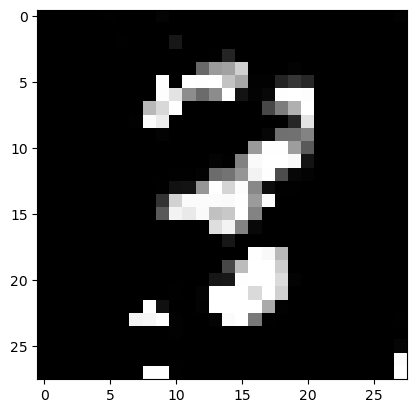

In [ ]:
Noise = torch.randn(6131, 4, device=device)  # GPU로 생성
X_fake = net_faker(Noise[0])
plt.imshow(X_fake.to("cpu").data.reshape(28,28),cmap="gray")

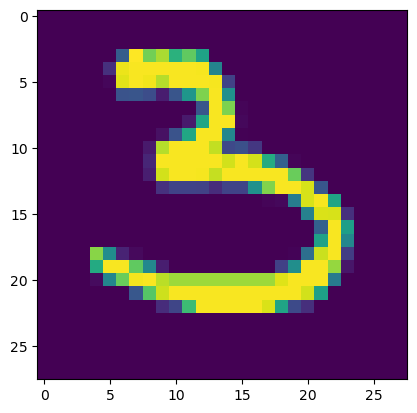

In [ ]:
plt.imshow(X_real[[0]].reshape(28,28).to("cpu").detach())

In [ ]:
net_police(X_real[[320]]) , net_police(net_faker(Noise[1000]))

(tensor([[0.0062]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.4382]], device='cuda:0', grad_fn=<SigmoidBackward0>))

2. 간단한 CNN 을 Descriptor 로 한 GAN모델 with cuda

In [2]:
# 2. 간단한 CNN 을 Descriptor 로 한 GAN모델 with cuda
import torch 
import torchvision
import fastai.vision.all 
import matplotlib.pyplot as plt 
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 GPU 사용, 없으면 CPU 사용

def plot_loss(loss_history_police, loss_history_faker, ax=None):
    epochs = range(len(loss_history_police))
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(epochs, loss_history_police, label="Discriminator Loss (net_police)")
    ax.plot(epochs, loss_history_faker, label="Generator Loss (net_faker)")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("GAN Losses Over Time")

def learn_and_record(net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake):
    loss_history_police = []
    loss_history_faker = []
    fake_images_history = []

    for epoc in range(1000):
        ## 판별자 (net_police) 훈련
        Noise = torch.randn(6131, 4, device=device)  # GPU로 생성
        X_fake = net_faker(Noise).detach()

        # 진짜 이미지와 가짜 이미지에 대한 예측
        yhat_real = net_police(X_real)
        yhat_fake = net_police(X_fake)

        # 손실 계산
        loss_police = loss_fn(yhat_real, y_real) + loss_fn(yhat_fake, y_fake)
        loss_police.backward()
        optimizr_police.step()
        optimizr_police.zero_grad()

        # 생성자 (net_faker) 훈련
        Noise = torch.randn(6131, 4, device=device)  # GPU로 생성
        X_fake = net_faker(Noise)

        # 가짜 이미지에 대한 예측
        yhat_fake = net_police(X_fake)
        loss_faker = loss_fn(yhat_fake, y_real)
        loss_faker.backward()
        optimizr_faker.step()
        optimizr_faker.zero_grad()

        # 매 100번의 epoch마다 손실과 생성된 이미지를 기록
        if epoc % 100 == 0:
            loss_history_police.append(loss_police.item())
            loss_history_faker.append(loss_faker.item())
            fake_images_history.append(X_fake[:10].detach().cpu())  # 일부 가짜 이미지 저장

    return loss_history_police, loss_history_faker, fake_images_history

def show_animation(net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake):
    loss_history_police, loss_history_faker, fake_images_history = learn_and_record(
        net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake
    )

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)  # Loss 그래프
    ax2 = fig.add_subplot(1, 2, 2)  # 생성된 이미지

    # Loss 그래프 업데이트
    def animate(epoc):
        ax1.clear()
        plot_loss(loss_history_police[:epoc], loss_history_faker[:epoc], ax1)
        ax2.clear()
        ax2.imshow(torchvision.utils.make_grid(fake_images_history[epoc], nrow=5).permute(1, 2, 0))
        fig.suptitle(f"Epoch {epoc * 100}")

    ani = animation.FuncAnimation(fig, animate, frames=len(fake_images_history), interval=200)
    plt.close()
    return ani

path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST)
X_real = torch.stack([torchvision.io.read_image(str(l)) for l in (path/'training/3').ls()],axis=0).float().div(255).to(device)  # GPU로 이동
y_real = torch.tensor([0]*6131, device=device).reshape(-1,1).float()   # real GPU로 이동
y_fake = torch.tensor([1]*6131, device=device).reshape(-1,1).float()   # fake GPU로 이동

class Reshape2828(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.reshape(-1,1,28,28)

torch.manual_seed(43052)

net_police = torch.nn.Sequential(
    # torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),  # 큰 커널로 초기 특징 추출
    # torch.nn.BatchNorm2d(64),
    # torch.nn.ReLU(),
    # torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),      # (64, 14, 14) -> (64, 7, 7)
    
    # torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    # torch.nn.BatchNorm2d(128),
    # torch.nn.ReLU(),
    
    # torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    # torch.nn.BatchNorm2d(256),
    # torch.nn.ReLU(),
    
    # torch.nn.Flatten(),
    # torch.nn.Linear(256 * 7 * 7, 128),
    # torch.nn.ReLU(),
    # torch.nn.Linear(128, 1),
    torch.nn.Conv2d(1,16,kernel_size=(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(2,2)),
    torch.nn.Conv2d(16,4,kernel_size=(5,5)),
    # torch.nn.ReLU(),
    # torch.nn.MaxPool2d(kernel_size=(2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(8*8*4,1),
    # torch.nn.Linear(4*4*4,1),


    torch.nn.Sigmoid()

    
    
).to(device)  # GPU로 이동

net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64) 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)   
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784) 
    torch.nn.Sigmoid(), 
    Reshape2828()
).to(device)  # GPU로 이동

bce = torch.nn.BCELoss().to(device)  # 손실 함수도 GPU로 이동
optimizr_police = torch.optim.Adam(net_police.parameters(),lr=0.001,betas=(0.5,0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(),lr=0.0002,betas=(0.5,0.999))

show_animation(net_police, net_faker, bce, optimizr_police, optimizr_faker, X_real, y_real, y_fake)


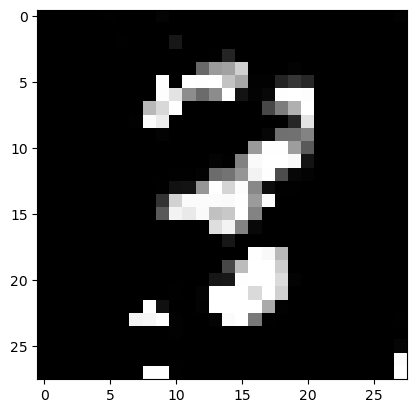

In [58]:
Noise = torch.randn(6131, 4, device=device)  # GPU로 생성
X_fake = net_faker(Noise[0])
plt.imshow(X_fake.to("cpu").data.reshape(28,28),cmap="gray")

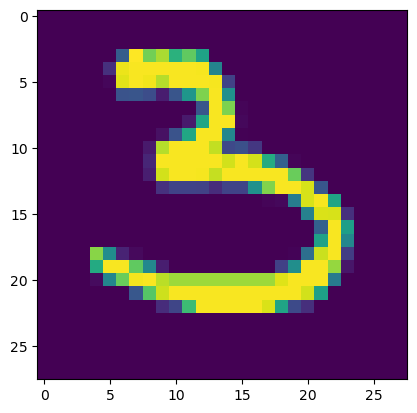

In [29]:
plt.imshow(X_real[[0]].reshape(28,28).to("cpu").detach())

In [56]:
net_police(X_real[[320]]) , net_police(net_faker(Noise[1000]))

(tensor([[0.0062]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.4382]], device='cuda:0', grad_fn=<SigmoidBackward0>))

DNN 을 Descriptor 로 한 GAN모델 with cuda

In [59]:
# DNN 을 Descriptor 로 한 GAN모델 with cuda
import torch 
import torchvision
import fastai.vision.all 
import matplotlib.pyplot as plt 
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_loss(loss_history_police, loss_history_faker, ax=None):
    epochs = range(len(loss_history_police))
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(epochs, loss_history_police, label="Discriminator Loss (net_police)")
    ax.plot(epochs, loss_history_faker, label="Generator Loss (net_faker)")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("GAN Losses Over Time")

def learn_and_record(net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake):
    loss_history_police = []
    loss_history_faker = []
    fake_images_history = []

    for epoc in range(1000):
        ## 판별자 (net_police) 훈련
        Noise = torch.randn(6131, 4, device=device)  # Noise도 GPU로 이동
        X_fake = net_faker(Noise).detach()

        # 진짜 이미지와 가짜 이미지에 대한 예측
        yhat_real = net_police(X_real)
        yhat_fake = net_police(X_fake)

        # 손실 계산
        loss_police = loss_fn(yhat_real, y_real) + loss_fn(yhat_fake, y_fake)
        loss_police.backward()
        optimizr_police.step()
        optimizr_police.zero_grad()

        # 생성자 (net_faker) 훈련
        Noise = torch.randn(6131, 4, device=device)  # Noise도 GPU로 이동
        X_fake = net_faker(Noise)

        # 가짜 이미지에 대한 예측
        yhat_fake = net_police(X_fake)
        loss_faker = loss_fn(yhat_fake, y_real)
        loss_faker.backward()
        optimizr_faker.step()
        optimizr_faker.zero_grad()

        # 매 100번의 epoch마다 손실과 생성된 이미지를 기록
        if epoc % 100 == 0:
            loss_history_police.append(loss_police.item())
            loss_history_faker.append(loss_faker.item())
            fake_images_history.append(X_fake[:10].detach().cpu())  # 일부 가짜 이미지 저장

    return loss_history_police, loss_history_faker, fake_images_history

def show_animation(net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake):
    loss_history_police, loss_history_faker, fake_images_history = learn_and_record(
        net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake
    )

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)  # Loss 그래프
    ax2 = fig.add_subplot(1, 2, 2)  # 생성된 이미지

    # Loss 그래프 업데이트
    def animate(epoc):
        ax1.clear()
        plot_loss(loss_history_police[:epoc], loss_history_faker[:epoc], ax1)
        ax2.clear()
        ax2.imshow(torchvision.utils.make_grid(fake_images_history[epoc], nrow=5).permute(1, 2, 0))
        fig.suptitle(f"Epoch {epoc * 100}")

    ani = animation.FuncAnimation(fig, animate, frames=len(fake_images_history), interval=200)
    plt.close()
    return ani

# 데이터셋을 GPU로 이동
path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST)
X_real = torch.stack([torchvision.io.read_image(str(l)) for l in (path/'training/3').ls()],axis=0).float().div(255).to(device)

class Reshape2828(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.reshape(-1,1,28,28)

torch.manual_seed(43052)

# 판별자 모델을 GPU로 이동
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784, out_features=30),
    torch.nn.ReLU(),
    # torch.nn.Linear(in_features=30, out_features=30),
    # torch.nn.ReLU(),
    torch.nn.Linear(in_features=30, out_features=1),
    torch.nn.Sigmoid()
).to(device)

# 생성자 모델을 GPU로 이동
net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64) 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)   
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784) 
    torch.nn.Sigmoid(), 
    Reshape2828()
).to(device)

# 레이블을 GPU로 이동
y_real = torch.tensor([0]*6131, device=device).reshape(-1,1).float()   # real
y_fake = torch.tensor([1]*6131, device=device).reshape(-1,1).float()   # fake

# 손실 함수도 GPU로 이동
bce = torch.nn.BCELoss().to(device)

# 최적화 함수 설정
optimizr_police = torch.optim.Adam(net_police.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 애니메이션 실행
show_animation(net_police, net_faker, bce, optimizr_police, optimizr_faker, X_real, y_real, y_fake)


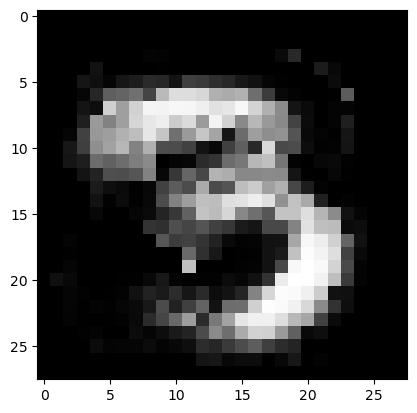

In [35]:
Noise = torch.randn(6131, 4, device=device)  # GPU로 생성
X_fake = net_faker(Noise[0])
plt.imshow(X_fake.to("cpu").data.reshape(28,28),cmap="gray")

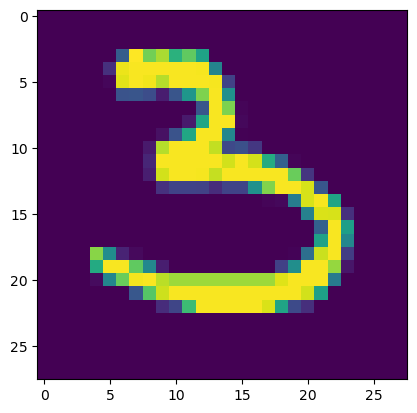

In [36]:
plt.imshow(X_real[[0]].reshape(28,28).to("cpu").detach())

In [40]:
net_police(X_real[[320]]) , net_police(net_faker(Noise[10]))

(tensor([[0.0085]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.4959]], device='cuda:0', grad_fn=<SigmoidBackward0>))

In [18]:
((yhat_real > 0.5) == 0).float().mean().item()


tensor([[6.3632e-05],
        [1.2178e-06],
        [4.2854e-05],
        ...,
        [1.2583e-04],
        [1.7823e-05],
        [3.6237e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)

# 강의 시작

In [1]:
import torch 
import torchvision
import fastai.vision.all 
import matplotlib.pyplot as plt 


In [2]:
def plot_loss(loss_history_police, loss_history_faker, ax=None):
    epochs = range(len(loss_history_police))
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(epochs, loss_history_police, label="Discriminator Loss (net_police)")
    ax.plot(epochs, loss_history_faker, label="Generator Loss (net_faker)")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("GAN Losses Over Time")


In [3]:
def learn_and_record(net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake):
    loss_history_police = []
    loss_history_faker = []
    fake_images_history = []
    success_rate_history = []  # 페이커의 사기 성공 비율 기록

    for epoc in range(1000):
        ## 판별자 (net_police) 훈련
        Noise = torch.randn(6131, 4)
        X_fake = net_faker(Noise).data

        # 진짜 이미지와 가짜 이미지에 대한 예측
        yhat_real = net_police(X_real)
        yhat_fake = net_police(X_fake)

        # 손실 계산
        loss_police = loss_fn(yhat_real, y_real) + loss_fn(yhat_fake, y_fake)
        loss_police.backward()
        optimizr_police.step()
        optimizr_police.zero_grad()

        # 생성자 (net_faker) 훈련
        Noise = torch.randn(6131, 4)
        X_fake = net_faker(Noise)

        # 가짜 이미지에 대한 예측
        yhat_fake = net_police(X_fake)
        loss_faker = loss_fn(yhat_fake, y_real)
        loss_faker.backward()
        optimizr_faker.step()
        optimizr_faker.zero_grad()

        # 매 100번의 epoch마다 손실과 생성된 이미지를 기록
        if epoc % 100 == 0:
            loss_history_police.append(loss_police.item())
            loss_history_faker.append(loss_faker.item())
            fake_images_history.append(X_fake[:10].detach().cpu())  # 일부 가짜 이미지 저장

    return loss_history_police, loss_history_faker, fake_images_history


In [4]:
def show_animation(net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake):
    loss_history_police, loss_history_faker, fake_images_history, success_rate_history = learn_and_record(
        net_police, net_faker, loss_fn, optimizr_police, optimizr_faker, X_real, y_real, y_fake
    )

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)  # Loss 그래프
    ax2 = fig.add_subplot(1, 2, 2)  # 생성된 이미지
    ax3 = fig.add_subplot(1, 1, 1)  # 성능 지표 (추가된 부분)

    # Loss 그래프 업데이트
    def animate(epoc):
        ax1.clear()
        plot_loss(loss_history_police[:epoc], loss_history_faker[:epoc], ax1)
        ax2.clear()
        ax2.imshow(torchvision.utils.make_grid(fake_images_history[epoc], nrow=5).permute(1, 2, 0))
        ax3.clear()
        ax3.plot(success_rate_history[:epoc])
        ax3.set_title(f"Epoch {epoc * 100} / Faker success rate: {success_rate_history[epoc]}")
        fig.suptitle(f"Epoch {epoc * 100}")

    ani = animation.FuncAnimation(fig, animate, frames=len(fake_images_history), interval=200)
    plt.close()
    return ani

In [5]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

# 3. GAN [@goodfellow2014generative] intro

`-` 저자: 이안굿펠로우 

- 천재임 
- 지도교수가 요수아 벤지오 

`-` 저는 아래의 논문 읽고 소름돋았어요.. 

- https://arxiv.org/abs/1406.2661 (2021-09, 38751회 인용.. $\to$ 2022-09, 48978회 인용.. $\to$ 2024-03, 66609 인용..)

`-` 최근 10년간 머신러닝 분야에서 가장 혁신적인 아이디어이다. (얀르쿤, 2014년 시점..) 

`-` 무슨내용? 생성모형 

## A. 생성모형이란? (쉬운 설명)

> 만들수 없다면 이해하지 못한 것이다, 리처드 파인만 (천재 물리학자) 

`-` 사진속에 들어있는 동물이 개인지 고양이인지 맞출수 있는 기계와 개와 고양이를 그릴수 있는 기계중 어떤것이 더 시각적보에 대한 이해가 깊다고 볼 수 있는가? 

`-` 진정으로 인공지능이 이미지자료를 이해했다면, 이미지를 만들수도 있어야 한다. $\to$ 이미지를 생성하는 모형을 만들어보자 $\to$ 성공 

![](https://upload.wikimedia.org/wikipedia/commons/1/1f/Woman_1.jpg){width=70%}

## B. GAN의 응용분야

`-` 내가 찍은 사진이 피카소의 화풍으로 표현된다면?

`-` 퀸의 라이브에이드가 4k로 나온다면?

`-` 1920년대 서울의 모습이 칼라로 복원된다면? 

`-` 딥페이크: 유명인의 가짜 포르노, 가짜뉴스, 협박(거짓기소) 


`-` 거북이의 커버.. 

`-` 너무 많아요.....

## C. 생성모형이란? 통계학과 버전의 설명 

> 제한된 정보만으로 어떤 문제를 풀 때, 그 과정에서 원래의 문제보다 일반적인 문제를 풀지 말고 (=문제를 괜히 어렵게 만들어서 풀지 말고), 가능한 원래의 문제를 직접 풀어야한다. 배프닉 (SVM 창시자) 

`-` 이미지 $\boldsymbol{X}$ 가 주어졌을 경우 라벨을 $y$ 라고 하자. 

`-` 이미지를 보고 라벨을 맞추는 일은 $p(y| \boldsymbol{X})$에 관심이 있다. -- 판별모형

`-` 이미지를 생성하는 일은 $p(\boldsymbol{X},y)$에 관심이 있는것이다. -- 생성모형

`-` 데이터의 생성확률 $p(\boldsymbol{X},y)$을 알면 클래스의 사후확률 $p(y|\boldsymbol{X})$를 알 수 있음. (아래의 수식 참고) 하지만 역은 불가능 

$$p(y|{\boldsymbol X}) = \frac{p({\boldsymbol X},y)}{p({\boldsymbol X})} = \frac{p({\boldsymbol X},y)}{\sum_{y}p({\boldsymbol X},y)}$$

- 즉 이미지를 생성하는일은 분류문제보다 더 어려운 일이라 해석가능 

`-` 따라서 배프닉의 원리에 의하면 일반적인 분류문제를 해결할때 "판별모형이 생성모형보다 더 바람직한 접근법"이라 할 수 있음. 즉 개와 고양이를 구분할 때, 그려진 개와 고양이 사진을 잘 구분하면 되는 것이지 굳이 개와 고양이를 그릴줄 알아야하는건 아니라는 의미. 

`-` 예전에는 머신러닝의 응용분야가 "분류/회귀"에 한정된 느낌이었는데 요즘은 생성모형도 인기있음. 

## D. GAN의 원리

`-` GAN은 생성모형 중 하나임 

`-` GAN의 원리는 경찰과 위조지폐범이 서로 선의의(?) 경쟁을 통하여 서로 발전하는 모형으로 설명할 수 있다.

> The generative model can be thought of as analogous to a team of fakers,
trying to produce fake currency and use it without detection, while the discriminative model is
analogous to the police, trying to detect the counterfeit currency. Competition in this game drives
both teams to improve their methods until the counterfeits are indistiguishable from the genuine
articles.

`-` 서로 적대적인(adversarial) 네트워크(network)를 동시에 학습시켜 가짜이미지를 만든다(generate) 

`-` 무식한 상황극.. 

- 위조범: 가짜돈을 만들어서 부자가 되어야지! (가짜돈을 그림) 
- 경찰: (위조범이 만든 돈을 보고) 이건 가짜다! 
- 위조범: 걸렸군.. 더 정교하게 만들어야지.. 
- 경찰: 이건 진짠가?... --> 상사에게 혼남. 그것도 구분못하냐고 --> (판별능력 업그레이드) --> 이건 가짜다!! 
- 위조범: 더 정교하게 만들자.. 
- 경찰: 더 판별능력을 업그레이드 하자! 
- 반복.. 

`-` 굉장히 우수한 경찰조차도 진짜와 가짜를 구분하지 못할때(=진짜 이미지를 0.5의 확률로만 진짜라고 말할때 = 가짜 이미지를 0.5의 확률로만 가짜라고 말할때) 학습을 멈춘다. 

# 4. GAN의 구현

## A. Data 

In [6]:
path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST)
path

Path('/home/myuser/.fastai/data/mnist_png')

In [7]:
[torchvision.io.read_image(str(l)) for l in (path/'training/3').ls()]

[tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   0,  75, 255, 201, 223, 163, 193, 147,   0,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,  35, 248, 253, 253, 253, 253, 253, 252, 115,
             0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,   0,   0,   0,   4, 244, 253, 250, 227, 253, 253, 253, 252,
            50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
          [  0,   0,  

In [8]:
X_real = torch.stack([torchvision.io.read_image(str(l)) for l in (path/'training/3').ls()],axis=0)/255
X_real.shape

torch.Size([6131, 1, 28, 28])

In [ ]:
plt.imshow(X_real[0].reshape(28,28),cmap="gray")

## B. 페이커 생성

> "net_faker: noise $\to$ 가짜이미지" 를 만들자. 

`-` 네트워크의 입력: (n,??) 인 랜덤으로 뽑은 숫자. 

`-` 네트워크의 출력: (n,1,28,28)의 텐서 

In [ ]:
torch.randn(1,4) # 이게 들어온다고 상상하자. 하나의 observation.

In [9]:
class Reshape2828(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.reshape(-1,1,28,28) 

In [10]:
net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64) 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)   
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784) 
    torch.nn.Sigmoid(), # 출력을 0~1로 눌러주는 역할.. -- 저는 이 레이어가 일종의 문화충격이었어요.. (시그모이드를 이렇게 쓴다고??)
    Reshape2828()
)

In [ ]:
net_faker(torch.randn(1,4)).shape # 가짜이미지!

## C. 경찰 생성

> net_police: 진짜이미지 $\to$ 0 // 가짜이미지 $\to$ 1 와 같은 네트워크를 설계하자. 

`-` 네트워크의 입력: (n,1,28,28) 인 이미지 

`-` 네트워크의 출력: 0,1 

In [9]:
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)

## D. 바보경찰, 바보페이커

> 스토리를 전개해볼까? 

`-` 경찰네트워크가 가짜이미지를 봤을때 어떤 판단을 하는지, 진짜 이미지를 봤을떄 어떤 판단을 하는지 살펴보자. 

***<경찰이 진짜이미지를 봤다면>***

`-` 진짜이미지 

In [ ]:
plt.imshow(X_real[0].reshape(28,28),cmap="gray")

`-` 진짜 이미지를 경찰한테 한장 줘볼까? $\to$ yhat이 나올텐데, 이 값이 0이어야 함

In [ ]:
yhat_real = net_police(X_real[[0]]) # 이 값이 0이어야 하는데..
yhat_real

- 진짜 이미지가 입력으로 왔으므로 `yhat_real` $\approx$ `0` 이어야 함
- 그런데 0과 거리가 멀어보임. (=배운것이 없는 무능한 경찰)

***<경찰이 가짜이미지를 봤다면>***

`-` 가짜이미지 -- 데이터셋이 있는게 아니고 net_faker가 생성해야하는 데이터 

In [ ]:
Noise = torch.randn(1,4)
Noise

In [ ]:
net_faker(Noise).shape # 페이커가 만든 가짜 이미지

In [ ]:
plt.imshow(net_faker(Noise).data.reshape(28,28),cmap="gray")

- 누가봐도 가짜이미지

`-` 가짜 이미지를 경찰한테 한장 줘볼까? $\to$ yhat이 나올텐데, 이 값이 1이어야 함

In [ ]:
yhat_fake = net_police(net_faker(Noise).data) # 이 값이 1이어야 하는데..
yhat_fake

- 가짜 이미지가 입력으로 왔으므로 `yhat_fake` $\approx$ `1` 이어야 함
- 그런데 1과 거리가 멀어보임. (=배운것이 없는 무능한 경찰)

`-` 페이커의 무능함 (왼쪽 이미지를 가짜이미라고 만들어 놓았음) + 경찰의 무능함 (왼쪽과 오른쪽을 보고 뭐가 진짜인지도 모름)

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(net_faker(Noise).data.reshape(28,28),cmap="gray"); ax[0].set_title("fake")
ax[1].imshow(X_real[[0]].reshape(28,28),cmap="gray"); ax[1].set_title("real")

## E. 똑똑해진 경찰

In [ ]:
X_real.shape

`-` 데이터 정리 

- 원래 $n=6131$개의 이미지 자료가 있음. 이를 ${\bf X}_{real}$ 라고 하자. 따라서 ${\bf X}_{real}$ 의 차원은 (6131,1,28,28). 
- 위조범이 만든 가짜자료를 원래 자료와 같은 숫자인 6131개 만듦. 이 가짜자료를 ${\bf X}_{fake}$ 라고 하자. 따라서 ${\bf X}_{fake}$ 의 차원은 (6131,1,28,28). 
- 진짜자료는 0, 가짜자료는 1으로 라벨링. 

In [13]:
Noise = torch.randn(6131,4)     # n = 6131
X_fake = net_faker(Noise).data
y_real = torch.tensor([0]*6131).reshape(-1,1).float()   # real
y_fake = torch.tensor([1]*6131).reshape(-1,1).float()   # fake

In [ ]:
y_real.shape , y_fake.shape

In [ ]:
X_fake.shape , X_real.shape

`-` step1: X_real, X_fake를 보고 각가 yhat_real, yhat_fake를 만드는 과정 

In [21]:
yhat_real = net_police(X_real)
yhat_fake = net_police(X_fake)

`-` step2: 손실을 계산 -- 경찰의 미덕은 (1) 가짜이미지를 가짜라고 하고 (yhat_fake $\approx$ y_fake) (2) 진짜이미지를 진짜라고 해야한다. (yhat_real $\approx$ y_real)

In [ ]:
bce = torch.nn.BCELoss()
loss_police = bce(yhat_fake,y_fake) + bce(yhat_real,y_real)
loss_police

`-` step3~4는 별로 특별한게 없음. 그래서 바로 epoch을 진행시켜보자.

In [23]:
##
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)
bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police.parameters())
# Noise = torch.randn(6131,4) 

##
for epoc in range(50):
    Noise = torch.randn(6131,4) 
    X_fake = net_faker(Noise).data
    ## step1 
    yhat_real = net_police(X_real)  # 0이길 바람
    yhat_fake = net_police(X_fake)  # 1이길 바람
    ## step2
    loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake)
    ## step3 
    loss_police.backward()
    ## step4 
    optimizr_police.step()
    optimizr_police.zero_grad()

`-` 훈련된 경찰의 성능을 살펴보자. 

In [ ]:
net_police(X_real) # 거의 0으로!

In [ ]:
net_police(X_fake) # 거의 1로!

In [26]:
##
net_police2 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)
bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police2.parameters())
Noise = torch.randn(6131,4) 

##
for epoc in range(50):
    # Noise = torch.randn(6131,4) 
    X_fake = net_faker(Noise).data
    ## step1 
    yhat_real = net_police2(X_real)  # 0이길 바람
    yhat_fake = net_police2(X_fake)  # 1이길 바람
    ## step2
    loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake)
    ## step3 
    loss_police.backward()
    ## step4 
    optimizr_police.step()
    optimizr_police.zero_grad()

In [ ]:
net_police2(X_real) # 거의 0으로!

In [ ]:
net_police2(X_fake) # 거의 1로!

In [29]:
##
net_police3 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)
bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police3.parameters())
# Noise = torch.randn(6131,4) 
##
for epoc in range(50):
    # torch.manual_seed(5)
    Noise = torch.randn(6131,4) 
    X_fake = net_faker(Noise).data
    ## step1 
    yhat_real = net_police3(X_real)  # 0이길 바람
    yhat_fake = net_police3(X_fake)  # 1이길 바람
    ## step2
    loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake)
    ## step3 
    loss_police.backward()
    ## step4 
    optimizr_police.step()
    optimizr_police.zero_grad()

In [ ]:
net_police3(X_real) # 거의 0으로!

In [ ]:
net_police3(X_fake) # 거의 1로!

`-` 꽤 우수한 경찰이 되었음

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_fake[[-1]].data.reshape(28,28),cmap="gray"); ax[0].set_title("fake")
ax[1].imshow(X_real[[-1]].reshape(28,28),cmap="gray"); ax[1].set_title("real")

## F. 더 똑똑해지는 페이커

`-` step1: Noise $\to$ X_fake

In [33]:
Noise = torch.randn(6131,4)
X_fake = net_faker(Noise) 

`-` step2: 손실함수 -- 페이커의 미덕은 (잘 훈련된) 경찰이 가짜이미지를 진짜라고 판단하는 것. 즉 `yhat_fake` $\approx$ `y_real` 이어야 페이커의 실력이 우수하다고 볼 수 있음. 

In [34]:
yhat_fake = net_police(X_fake) 
loss_faker = bce(yhat_fake,y_real) ## 가짜이미지를 보고 잘 훈련된 경찰조차 진짜이미지라고 깜빡 속으면 위조범의 실력이 좋은 것임

`-` step3~4는 별로 특별한게 없음. 그래서 바로 epoch을 진행시켜보자.

In [35]:
net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64) 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)   
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784) 
    torch.nn.Sigmoid(), # 출력을 0~1로 눌러주는 역할.. -- 저는 이 레이어가 일종의 문화충격이었어요.. (시그모이드를 이렇게 쓴다고??)
    Reshape2828()
)
#bce = torch.nn.BCELoss()
optimizr_faker = torch.optim.Adam(net_faker.parameters())
#--#

In [36]:
for epoc in range(10):
    # step1
    Noise = torch.randn(6131,4) 
    X_fake = net_faker(Noise) 
    # step2
    yhat_fake = net_police(X_fake) 
    loss_faker = bce(yhat_fake,y_real)
    # step3 
    loss_faker.backward()
    # step4 
    optimizr_faker.step()
    optimizr_faker.zero_grad()

`-` 위조범의 실력향상을 감상해보자. 

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(10,4))
k = 0 
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(X_fake[k].reshape(28,28).data,cmap="gray")
        ax[i][j].set_title(f"police hat = {yhat_fake[k].item():.4f}")
        k = k+1 
fig.tight_layout()

In [ ]:
((yhat_fake > 0.5) == 0).float().mean() # 경찰이 가짜이미지를 진짜라고 생각한 비율 = 페이커가 사기에 성공한 비율

## G. 경쟁학습

> 두 적대적인 네트워크를 경쟁시키자!

In [ ]:
Noise = torch.randn(6131,4)     # n = 6131
X_fake = net_faker(Noise).data
y_real = torch.tensor([0]*6131).reshape(-1,1).float()   # real
y_fake = torch.tensor([1]*6131).reshape(-1,1).float()   # fake

In [11]:
torch.manual_seed(43052)
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)
net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64) 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)   
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784) 
    torch.nn.Sigmoid(), 
    Reshape2828()
)
bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police.parameters(),lr=0.001,betas=(0.5,0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(),lr=0.0002,betas=(0.5,0.999))

In [14]:
for epoc in range(1000):
    # net_police 을 훈련
    Noise = torch.randn(6131,4) 
    X_fake = net_faker(Noise).data # net_faker에 대한 미분꼬리표는 여기선 필요없으므로 .data 만을 이용
    ## step1 
    yhat_real = net_police(X_real)
    yhat_fake = net_police(X_fake)
    ## step2 
    loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake)
    ## step3 
    loss_police.backward()
    ## step4 
    optimizr_police.step()
    optimizr_police.zero_grad()
    # net_faker 를 훈련
    ## step1 
    Noise = torch.randn(6131,4) 
    X_fake = net_faker(Noise)
    ## step2 
    yhat_fake = net_police(X_fake)
    loss_faker = bce(yhat_fake,y_real) 
    ## step3
    loss_faker.backward()
    ## step4 
    optimizr_faker.step()
    optimizr_faker.zero_grad()

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(10,4))
k = 0 
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(X_fake[k].reshape(28,28).data,cmap="gray")
        ax[i][j].set_title(f"police hat = {yhat_fake[k].item():.4f}")
        k = k+1 
fig.tight_layout()

CUDA 사용하여 학습 30000회

In [ ]:

# CUDA 사용 가능한지 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 임의의 시드 설정
torch.manual_seed(43052)

# 모델 정의
class Reshape2828(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 28, 28)  # (n, 784) -> (n, 28, 28)

net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784, out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30, out_features=1),
    torch.nn.Sigmoid()
).to(device)

net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784),
    torch.nn.Sigmoid(),
    Reshape2828()
).to(device)




In [43]:
# 손실 함수와 옵티마이저
bce = torch.nn.BCELoss().to(device)
optimizr_police = torch.optim.Adam(net_police.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoc in range(30000):
    # net_police 훈련
    Noise = torch.randn(6131, 4).to(device) 
    X_fake = net_faker(Noise).detach()  # .detach() 사용하여 불필요한 그래디언트 추적 방지
    yhat_real = net_police(X_real.to(device))
    yhat_fake = net_police(X_fake)
    loss_police = bce(yhat_real, y_real.to(device)) + bce(yhat_fake, y_fake.to(device))
    loss_police.backward()
    optimizr_police.step()
    optimizr_police.zero_grad()

    # net_faker 훈련
    Noise = torch.randn(6131, 4).to(device)
    X_fake = net_faker(Noise)
    yhat_fake = net_police(X_fake)
    loss_faker = bce(yhat_fake, y_real.to(device))
    loss_faker.backward()
    optimizr_faker.step()
    optimizr_faker.zero_grad()

In [ ]:
fig,ax = plt.subplots(3,5,figsize=(10,4))
k = 0 
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(X_fake[k].to("cpu").reshape(28,28).data,cmap="gray")
        ax[i][j].set_title(f"police hat = {yhat_fake[k].item():.4f}")
        k = k+1 
fig.tight_layout()

CUDA 사용하여 학습 10000회

In [ ]:

# CUDA 사용 가능한지 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 임의의 시드 설정
torch.manual_seed(43052)

# 모델 정의
class Reshape2828(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 28, 28)  # (n, 784) -> (n, 28, 28)

net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784, out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30, out_features=1),
    torch.nn.Sigmoid()
).to(device)

net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784),
    torch.nn.Sigmoid(),
    Reshape2828()
).to(device)




In [46]:
# 손실 함수와 옵티마이저
bce = torch.nn.BCELoss().to(device)
optimizr_police = torch.optim.Adam(net_police.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoc in range(10000):
    # net_police 훈련
    Noise = torch.randn(6131, 4).to(device) 
    X_fake = net_faker(Noise).detach()  # .detach() 사용하여 불필요한 그래디언트 추적 방지
    yhat_real = net_police(X_real.to(device))
    yhat_fake = net_police(X_fake)
    loss_police = bce(yhat_real, y_real.to(device)) + bce(yhat_fake, y_fake.to(device))
    loss_police.backward()
    optimizr_police.step()
    optimizr_police.zero_grad()

    # net_faker 훈련
    Noise = torch.randn(6131, 4).to(device)
    X_fake = net_faker(Noise)
    yhat_fake = net_police(X_fake)
    loss_faker = bce(yhat_fake, y_real.to(device))
    loss_faker.backward()
    optimizr_faker.step()
    optimizr_faker.zero_grad()

In [ ]:
fig,ax = plt.subplots(3,5,figsize=(10,4))
k = 0 
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(X_fake[k].to("cpu").reshape(28,28).data,cmap="gray")
        ax[i][j].set_title(f"police hat = {yhat_fake[k].item():.4f}")
        k = k+1 
fig.tight_layout()

CUDA 사용하여 학습 1000회

In [ ]:

# CUDA 사용 가능한지 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 임의의 시드 설정
torch.manual_seed(43052)

# 모델 정의
class Reshape2828(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 28, 28)  # (n, 784) -> (n, 28, 28)

net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784, out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30, out_features=1),
    torch.nn.Sigmoid()
).to(device)

net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784),
    torch.nn.Sigmoid(),
    Reshape2828()
).to(device)


# 손실 함수와 옵티마이저
bce = torch.nn.BCELoss().to(device)
optimizr_police = torch.optim.Adam(net_police.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [49]:
for epoc in range(100):
    # net_police 훈련
    Noise = torch.randn(6131, 4).to(device) 
    X_fake = net_faker(Noise).detach()  # .detach() 사용하여 불필요한 그래디언트 추적 방지
    yhat_real = net_police(X_real.to(device))
    yhat_fake = net_police(X_fake)
    loss_police = bce(yhat_real, y_real.to(device)) + bce(yhat_fake, y_fake.to(device))
    loss_police.backward()
    optimizr_police.step()
    optimizr_police.zero_grad()

    # net_faker 훈련
    Noise = torch.randn(6131, 4).to(device)
    X_fake = net_faker(Noise)
    yhat_fake = net_police(X_fake)
    loss_faker = bce(yhat_fake, y_real.to(device))
    loss_faker.backward()
    optimizr_faker.step()
    optimizr_faker.zero_grad()

In [ ]:
fig,ax = plt.subplots(3,5,figsize=(10,10))
k = 0 
for i in range(3):
    for j in range(5):
        ax[i][j].imshow(X_fake[k].to("cpu").reshape(28,28).data,cmap="gray")
        ax[i][j].set_title(f"police hat = {yhat_fake[k].item():.4f}")
        k = k+1 
fig.tight_layout()

# 5. 초기 GAN의 한계점 

`-` 두 네트워크의 균형이 매우 중요함 -- 균형이 깨지는 순간 학습은 실패함

`-` 생성되는 이미지의 다양성이 부족한 경우가 발생함. (mode collapse)